<a href="https://colab.research.google.com/github/steffenmodest/ARC/blob/master/Kopie_von_iX_Developer_Unsupervised_Learing_Anomalieerkennung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Die gebräuchlichsten Imports

- `numpy`, abgekürzt als `np` für numerische Berechnungen, insbesondere mit Vektoren
- `matplotlib`, abgekürzt als `plt` für eine Matlab-ähnliches Interface zum Zeichnen von Diagrammen.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rs = 23  # fester Random Seed

# Daten laden und vorbereiten

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

# Fashion MNIST Daten laden, wir wollen nur die Trainingsdaten und verwerfen die Testdaten
(X_orig, y_orig), (_, _) = fashion_mnist.load_data()

# Außerdem reduzieren wir den Datensatz auf eine Klasse: Hosen
category = 1  # Trousers
X_orig = X_orig[y_orig == category]

print(X_orig.shape)  # (6000, 28, 28) -> 6000 Hosen mit je 28 x 28 Pixeln

(6000, 28, 28)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, FunctionTransformer

# Plätte 2D Bild in einen Vektor:
# Reshape behält die Anzahl Element in der ersten Dimension (len(X_orig) -> #Bilder)
# die restlichen Zellen des Arrays (-1 -> Pixel) bekommen alle ihre eigene Dimension
X = X_orig.reshape(len(X_orig), -1).astype('float64')

# Dimensionen um den Mittelpunkt zentrieren
preproccessing = StandardScaler()
X = preproccessing.fit_transform(X)

print ("Originaldaten:")
print("Shape: {}, Mean: {:f}, STD: {:f}".format(X_orig.shape, np.mean(X_orig), np.std(X_orig)))

print ("Vorbereitete Daten:")
print("Shape: {}, Mean: {:f}, STD: {:f}".format(X.shape, np.mean(X), np.std(X)))

Originaldaten:
Shape: (6000, 28, 28), Mean: 56.840855, STD: 87.600263
Vorbereitete Daten:
Shape: (6000, 784), Mean: 0.000000, STD: 0.991675


# Visualisierungsfunktionen

In [ ]:
# Berechne eine 2D Darstellung des Datensatzes
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2, random_state=rs).fit_transform(X)
print(embedding.shape)

(6000, 2)


In [ ]:
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


def showImage(data):
    'Zeichne das Bild data in der originalen Struktur (28x28 Pixel)'
    plt.imshow(data.reshape(28, 28), cmap='Greys')
    plt.gca().set(xticks=[], yticks=[])


def plot_scores(score, threshold=0, ax=None):
    '''
    Sortiere die Score uns zeichne sie in in Bild ax fals angegeben.'
    Wenn ein Score threshold angegeben ist, werden alle Outlier lila gemalt,
    ansonsten wird der Score als Farbverlauf angzeigt.
    '''
    if ax == None:
        fig, ax = plt.subplots()

    ax.set(xticks=[])
    
    order = score.argsort()
    if threshold > 0:
        outlier = score > threshold
        ax.scatter(range(len(score)), score[order], c=~outlier[order], marker='o')
    else:
        ax.scatter(range(len(score)), score[order], c=-score[order], marker='o')
    ax.plot(score[order])


def plot_map(embedding, score, threshold=0, draw_circles=False, alpha=0.5, ax=None):
    'Zeichne die Bilder als Punkte in einem 2D Raum, selbes Farmapping wie plot_scores'
    if ax == None:
        fig, ax = plt.subplots()
        
    ax.set(xticks=[], yticks=[])

    if threshold > 0:
        outlier = score > threshold
        ax.scatter(embedding[:,0],embedding[:,1], alpha=alpha, c=~outlier, label='Datenpunkte')
    else:
        ax.scatter(embedding[:,0],embedding[:,1], alpha=alpha, c=-score)
        
    if draw_circles:
        ax.scatter(embedding[:, 0], embedding[:, 1], s=1000 * score, edgecolors='r', facecolors='none', label='Anomaliescore')
    

def show_samples(data, score, fraction=0.01, samples=5, random_state=rs):
    'Zeichne jeweils 5 zufällige aus dem obersten Prozent der normalsten und abnormalsten Hosen.'
    fig = plt.figure(figsize=(8*samples,12))
    draw_top_samples(data, score, fig, 211, fraction, samples, random_state)
    plt.show()


def draw_top_samples(data, score, figure, subplot, fraction=0.01, samples=5, random_state=rs):
    'Zeichne jeweils 5 zufällige aus dem obersten Prozent der normalsten und abnormalsten Hosen.'
    grid = ImageGrid(figure, subplot, nrows_ncols=(2, samples), axes_pad=0.1)

    top = (score).argsort()[:int(len(data)*fraction)]
    random.Random(random_state).shuffle(top)
    sample = top[:samples]
    grid[0].set_ylabel("Norm",size='large')
    grid[samples].set_ylabel("Anomalie",size='large')
    
    for axi, i_img in zip(grid[:samples], sample):
        axi.set(xticks=[], yticks=[])
        axi.imshow(data[i_img].reshape(28,28), interpolation='nearest', cmap=plt.cm.binary)
        axi.set_title('{:.3f}'.format(abs(score[i_img])))
    
    top = (-score).argsort()[:int(len(data)*fraction)] 
    top = top[score[top]>0] # spezialfall wenn zu wenig outlier existieren
    random.Random(random_state).shuffle(top)
    sample = top[:samples]
    
    for axi, i_img in zip(grid[samples:], sample):
        axi.set(xticks=[], yticks=[])
        axi.imshow(data[i_img].reshape(28,28), interpolation='nearest', cmap=plt.cm.binary)
        axi.set_xlabel('{:.3f}'.format(abs(score[i_img])),size='large')

    
def scale_score(score):
    'Skaliere den Score in den bereich [0,1] damit die Farbverläufe gleich sind.'
    return (score - score.min()) / (score.max() - score.min())

# Anomalien mit DBSCAN

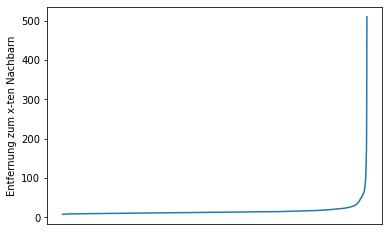

In [ ]:
# Zuerst suchen wir wieder nach sinnvollen Werte für minPts und epsilon:

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

minPts = 30

# wir schauen für jeden Punkt wie weit der (minPts-1)te Nachbar weg ist.
nearest_neighbors = NearestNeighbors(n_neighbors=(minPts-1))
nearest_neighbors.fit(X)
distances, _ = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, -1]

# Zeichne das Bild
plt.plot(distances)
plt.xticks([])
plt.ylabel('Entfernung zum x-ten Nachbarn')
plt.show()

In [ ]:
# Clustering berechnen
epsilon = 80.0
dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
clusters = dbscan.fit_predict(X)

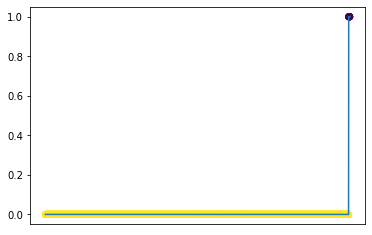

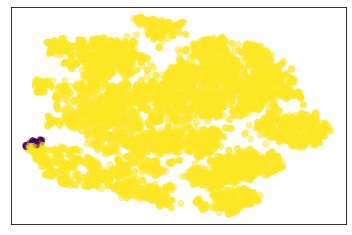

In [ ]:
# Ergebnis darstellen

db_score = (clusters == -1).astype('int')
plot_scores(db_score)
plt.show()

plot_map(embedding, db_score)
plt.show()

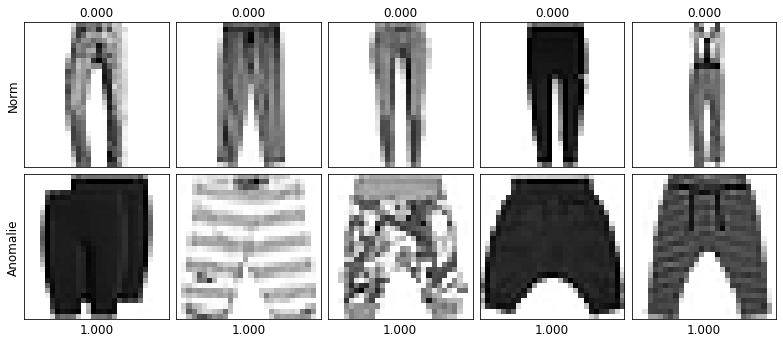

In [ ]:
show_samples(X_orig, db_score, random_state=42)

# Anomalien mit Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=30, contamination='auto')
outfactors = lof.fit_predict(X)

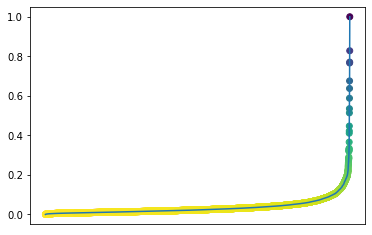

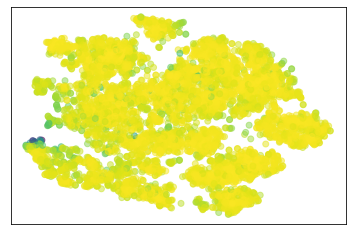

In [ ]:
lof_score = scale_score(-lof.negative_outlier_factor_)

plot_scores(lof_score)
plt.show()

plot_map(embedding, lof_score)
plt.show()

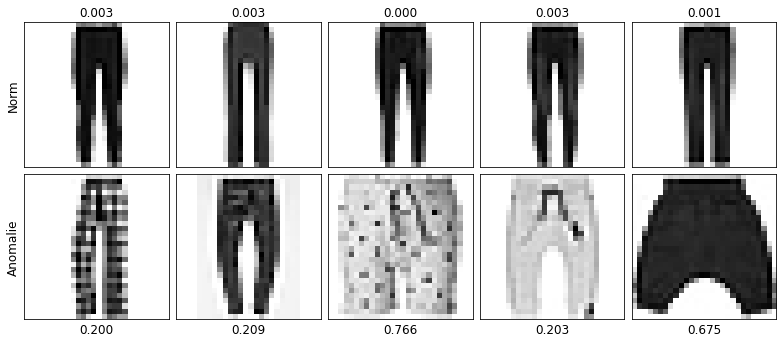

In [ ]:
show_samples(X_orig, lof_score)

# Anomalien mit Autoencoder

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Ein sehr einfacher Autoencoder mit nur einer Encoding- und einer Decoding-Schicht.

# auf diese Anzahl an Werten reduzieren wir das Bild
encoding_dim = 5

# encoding layer
input_img = Input(shape=(784,))  # wie viele Werte hat die Eingabe (ein Bild)
encoded = Dense(encoding_dim, activation='relu')(input_img)  # reduzieren des inputs auf encoding_dim Werte

# decoding layer
decoded = Dense(784, activation='linear')(encoded)  # Wiederherstellen der ursprünglichen Größe

# Eine "Sicht" auf das Netzwerk, mit der wir die Schichten trainieren werden
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')  # MSE berechnet den Rekonstruktionsfehler
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3925      
_________________________________________________________________
dense_1 (Dense)              (None, 784)               4704      
Total params: 8,629
Trainable params: 8,629
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Das Trainieren funktioniert analog zu den bekannten Scikit-Learn-Klassen mit der Funktion `fit`.

history = autoencoder.fit(
    X,  # Eingabe
    X,  # erwartete Ausgabe
    epochs=(600000//len(X)),  # so oft werden die Daten wiederholt
    batch_size=128, verbose=False, shuffle=True)
print("final loss", history.history['loss'][-1], "after", len(history.history['loss']), "epochs")

final loss 0.990969717502594 after 100 epochs


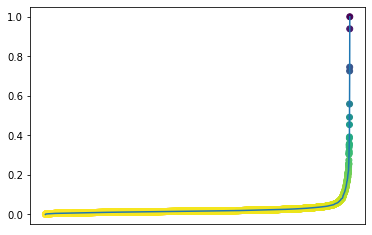

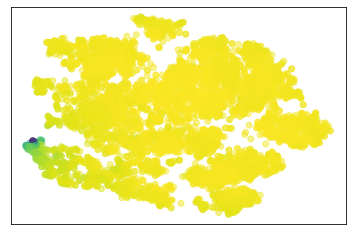

In [ ]:
# den Datensatz ein mal durch den Autoencoder schieben und alle Fehler berechnen
reconstructed_images = autoencoder.predict(X)
reconstruction_error = np.linalg.norm((X - reconstructed_images), axis=1)  # dasselbe wie MSE

ae_score = scale_score(reconstruction_error)

plot_scores(ae_score)
plt.show()

plot_map(embedding, ae_score)
plt.show()

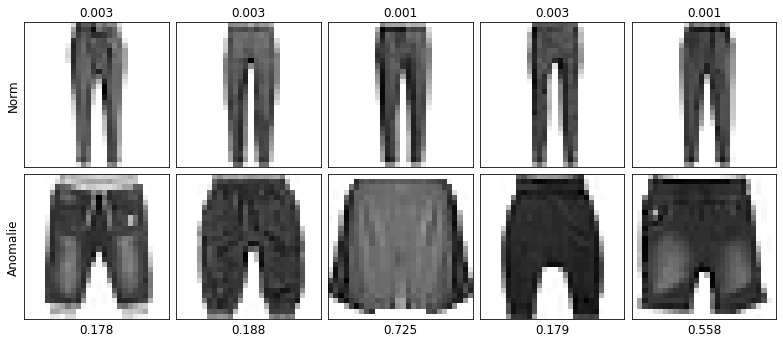

In [ ]:
show_samples(X_orig, ae_score)

# Alles zusammen in ein Bild

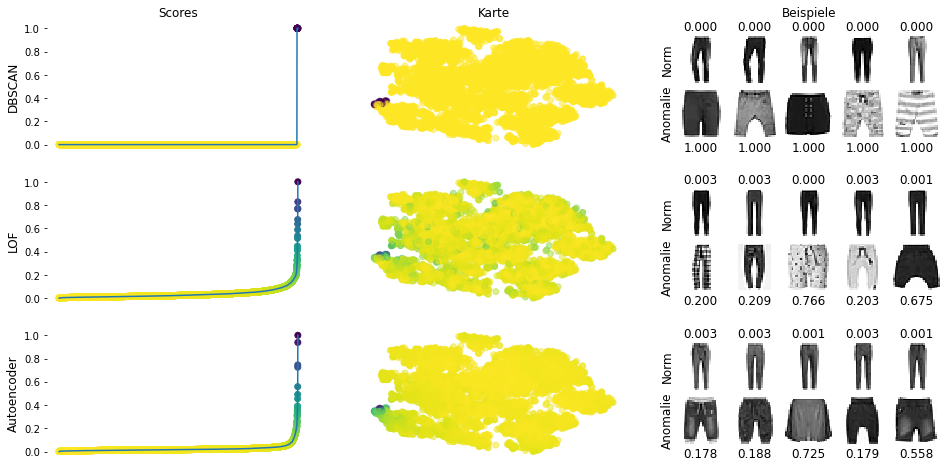

In [ ]:
rows = ['DBSCAN', 'LOF', 'Autoencoder']
scores = [db_score, lof_score, ae_score]
cols = ['Scores', 'Karte', 'Beispiele']

# fig = plt.figure(figsize=(16,8))

# Basis Grid 3x3
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    
# Spaltennamen setzen
for i in range(3):
    axes[0][i].set_title(cols[i])

# Zeilen
for i in range(3):
    # Zeilennamen setzen
    axes[i][0].set_ylabel(rows[i], size='large')
    
    plot_scores(scores[i], ax=axes[i][0])

    plot_map(embedding, scores[i], ax=axes[i][1])

    axes[i][2].set(xticks=[], yticks=[])
    bbox = axes[i][2].get_position()
    draw_top_samples(X_orig, scores[i], figure=fig, subplot=(bbox.xmin, bbox.ymin, bbox.width, bbox.height))

# störende Achsen und Boxen entfernen
sns.despine(left=True, bottom=True, right=True)

plt.show()

# Das LOF Beispielbild

In [ ]:
# Einfache Beispieldaten erzeugen
from sklearn.datasets import make_blobs
n = 100
X_ex, _ = make_blobs(n_samples=n, random_state=4223)

In [ ]:
lof_ex = LocalOutlierFactor(n_neighbors=30, contamination='auto')
lof_ex.fit(X_ex)

LocalOutlierFactor(n_neighbors=30)

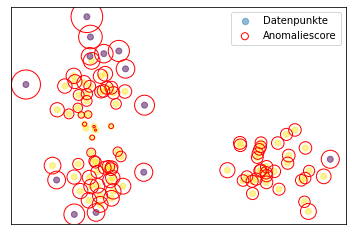

In [ ]:

lof_ex_score = scale_score(-lof_ex.negative_outlier_factor_)
plot_map(X_ex, lof_ex_score, threshold=0.3, draw_circles=True)

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [40]
legend.legendHandles[1]._sizes = [50]
plt.show()

# Das Autoencoder Beispielbild

Text(0.5, 0, 'Rekonstruktionsfehler: 115.027')

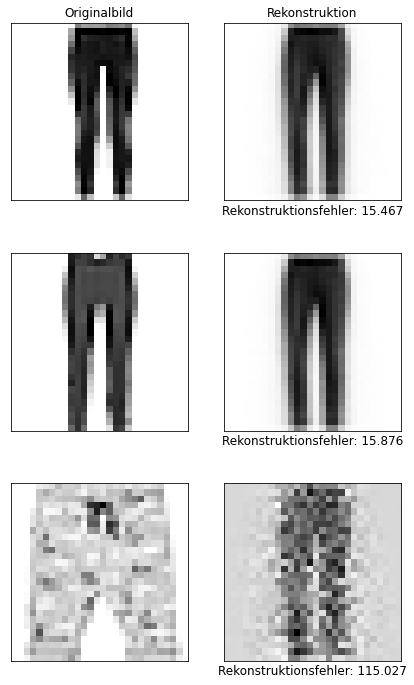

In [ ]:
denormalised = preproccessing.inverse_transform(reconstructed_images)

plt.figure(figsize=(7, 12))
subplot = 320

subplot += 1
plt.subplot(subplot)
plt.title("Originalbild")
showImage(X_orig[2])

subplot += 1
plt.subplot(subplot)
plt.title("Rekonstruktion")
showImage(denormalised[2])
plt.xlabel("Rekonstruktionsfehler: {:.3f}".format(reconstruction_error[2]), size='large')

subplot += 1
plt.subplot(subplot)
showImage(X_orig[13])

subplot += 1
plt.subplot(subplot)
showImage(denormalised[13])
plt.xlabel("Rekonstruktionsfehler: {:.3f}".format(reconstruction_error[13]), size='large')

subplot += 1
plt.subplot(subplot)
showImage(X_orig[21])

subplot += 1
plt.subplot(subplot)
showImage(denormalised[21])
plt.xlabel("Rekonstruktionsfehler: {:.3f}".format(reconstruction_error[21]), size='large')